# ISCAS Paper Work
See `ifat.py` for synaptic connetvitiy plots

In [1]:
from brian2 import *
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def visualize_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

In [77]:
def calc_weight(M, alpha, mu, sigma):
    alpha = alpha/fF
    output = zeros((M,M))
    for i in np.arange(M):
        for j in np.arange(M):
            output[i,j] = exp(cos((2*pi*i/M) - (2*pi*j/M) - mu)/sigma**2)
    output = output * (alpha/np.max(output))
    output = 5.0 * np.around(output/(5.0))
    output[output==0.] = nan
    return output

In [4]:
MODE = 'adaptive'
PARASITICS = True

In [5]:
# Define various equations

if MODE == 'adaptive':
    neuron_eq = '''
        dVm/dt = ((glm + gpar) / Cm) * (Vm_r - Vm)  : volt
        dVt/dt = ((glt + gpar) / Ct) * (Vt_r - Vt)  : volt
        
        # dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt
        # dVt/dt = (glt / Ct) * (Vt_r - Vt) : volt

        glm = flm * Cl                              : siemens
        glt = flt * Cl                              : siemens
        gpar = par_ctrl / par_leak_time * Cm : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
        Vt = Vt * (Vt > Vm) + Vt_r * (Vt <= Vm)
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
        Vt += (Cst/Ct) * (Vm_old - Vm_r)
    '''
else:
    neuron_eq = '''
        dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt

        glm = flm * Cl                    : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
    '''

# Synapse equation is the same for both modes!
syn_eq = '''
    Vsyn = (W/Cm)*(Em - Vm) : volt
    Em                      : volt
    W                       : farad
'''

In [6]:
# IFAT specific definitions
fF = 0.001 * pF
Vdd = 5 * volt
Cm = Ct = 440 * fF
Cl = 2 * fF

W_vals  = np.array([5, 10, 20, 40, 80]) * fF
Em_vals = np.array([0, 1/3, 2/3, 1]) * Vdd

par_ctrl = True
par_ctrl = float(PARASITICS)
par_leak_time = 12.5 * ms

In [7]:
# Model parameters
Vm_r = 1 * volt
flm  = 0 * kHz
Csm  = W_vals[0]

Vt_r = 3.5 * volt
flt  = 0 * MHz
Cst  = 0 * fF

M = 64

In [8]:
# Connectivity specifics
alpha = sum(W_vals)
mu1 = 0
mu2 = 2*pi/3
mu3 = pi
sigma = 36 * pi/180

In [ ]:
start_scope()

blair_exc = NeuronGroup(M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
blair_exc.Vt = Vt_r
blair_exc.Vm = Vm_r

blair_inh = NeuronGroup(M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
blair_inh.Vt = Vt_r
blair_inh.Vm = Vm_r

In [ ]:
exc2inh = Synapses(blair_exc, blair_inh, syn_eq, on_pre=presyn_eq)
exc2inh.connect()
exc2inh.Em = Em_vals[3]
exc2inh.W = calc_weight(M,alpha,mu1,sigma).flatten()

inh2exc = Synapses(blair_inh, blair_exc, syn_eq, on_pre=presyn_eq)
inh2exc.connect()
inh2exc.Em = Em_vals[0]
inh2exc.W  = calc_weight(M,alpha,mu2,sigma).flatten()

inh2inh = Synapses(blair_inh, blair_inh, syn_eq, on_pre=presyn_eq)
inh2inh.connect()
inh2inh.Em = Em_vals[0]
inh2inh.W = calc_weight(M,alpha,mu1,sigma).flatten()

In [ ]:
PoisIn = PoissonGroup(M,rates=0*kHz)
p2exc = Synapses(PoisIn, blair_exc, syn_eq, on_pre=presyn_eq)
p2exc.connect('j==i')
p2exc.Em = Em_vals[3]
p2exc.W = W_vals[2] + W_vals[0]# + W_vals[0]

In [ ]:
i_spmon = SpikeMonitor(blair_inh)
e_spmon = SpikeMonitor(blair_exc)
e_vmon = StateMonitor(blair_exc, 'Vm', record=True)
inrate = PopulationRateMonitor(PoisIn)
erate00 = PopulationRateMonitor(blair_exc[:1])
erate15 = PopulationRateMonitor(blair_exc[15:16])
erate31 = PopulationRateMonitor(blair_exc[31:32])
erate47 = PopulationRateMonitor(blair_exc[47:48])
ratecheck = StateMonitor(PoisIn, 'rates',record=True)
#irate = PopulationRateMonitor(blair_inh[:1])

In [ ]:
store()
poissonRates = arange(2.0,4.0,0.1)*kHz

In [ ]:
#rateOuts = zeros((4,20))
eRates00 = []; eRates00b = []; eRates00c = []
eRates15 = []; eRates15b = []; eRates15c = []
eRates31 = []; eRates31b = []; eRates31c = []
eRates47 = []; eRates47b = []; eRates47c = []

In [ ]:
BrianLogger.suppress_hierarchy('brian2.codegen.generators.base')
for thing in range(3):
    for poissonRate in poissonRates:
        restore()
        PoisIn.rates = poissonRate
        print(poissonRate)
        run(8*second,report='text')
        if thing == 0:
            eRates00.append(erate00.smooth_rate(width=100*ms))
            eRates15.append(erate15.smooth_rate(width=100*ms))
            eRates31.append(erate31.smooth_rate(width=100*ms))
            eRates47.append(erate47.smooth_rate(width=100*ms))
        elif thing == 1:
            eRates00b.append(erate00.smooth_rate(width=100*ms))
            eRates15b.append(erate15.smooth_rate(width=100*ms))
            eRates31b.append(erate31.smooth_rate(width=100*ms))
            eRates47b.append(erate47.smooth_rate(width=100*ms))
        else:
            eRates00c.append(erate00.smooth_rate(width=100*ms))
            eRates15c.append(erate15.smooth_rate(width=100*ms))
            eRates31c.append(erate31.smooth_rate(width=100*ms))
            eRates47c.append(erate47.smooth_rate(width=100*ms))

In [ ]:
figure(figsize=(8,6))
plot(e_spmon.t/ms, e_spmon.i,'.'); xlim([5000,5250])
xlabel('Time (ms)')
ylabel('Neuron index')

In [ ]:
rateWidth = 1000 * ms
plot(erate00.t/second, erate00.smooth_rate(width=rateWidth)/Hz,
     erate15.t/second, erate15.smooth_rate(width=rateWidth)/Hz,
     erate31.t/second, erate31.smooth_rate(width=rateWidth)/Hz,
     erate47.t/second, erate47.smooth_rate(width=rateWidth)/Hz)
xlim([2,6])

In [ ]:
idx = 32
plot(e_vmon.t/ms-5000, e_vmon.Vm[idx]); xlim([0,250])
scatter(e_spmon.t[e_spmon.i==idx]/ms-5000,3.65*ones(len(e_spmon.t[e_spmon.i==idx])),color='r')
xlabel('Time (ms)')
ylabel('Membrane Voltage (V)')

In [ ]:
smooth_width = 1000*ms

sig_shape = shape(eRates00)
avgRate = zeros(sig_shape)
avgRateB = zeros(sig_shape)
avgRateC = zeros(sig_shape)

for i in range(sig_shape[0]):
    avgRate[i,:]  = eRates00[i]#.smooth_rate(width=smooth_width)
    avgRate[i,:] += eRates15[i]#.smooth_rate(width=smooth_width)
    avgRate[i,:] += eRates31[i]#.smooth_rate(width=smooth_width)
    avgRate[i,:] += eRates47[i]#.smooth_rate(width=smooth_width)
    avgRate[i,:] = avgRate[i,:]/4
    avgRateB[i,:]  = eRates00b[i]#.smooth_rate(width=smooth_width)
    avgRateB[i,:] += eRates15b[i]#.smooth_rate(width=smooth_width)
    avgRateB[i,:] += eRates31b[i]#.smooth_rate(width=smooth_width)
    avgRateB[i,:] += eRates47b[i]#.smooth_rate(width=smooth_width)
    avgRateB[i,:] = avgRateB[i,:]/4
    avgRateC[i,:]  = eRates00c[i]#.smooth_rate(width=smooth_width)
    avgRateC[i,:] += eRates15c[i]#.smooth_rate(width=smooth_width)
    avgRateC[i,:] += eRates31c[i]#.smooth_rate(width=smooth_width)
    avgRateC[i,:] += eRates47c[i]#.smooth_rate(width=smooth_width)
    avgRateC[i,:] = avgRateC[i,:]/4

In [ ]:
plot(erate00.t/second, avgRateB[0,:]/Hz,
     erate00.t/second, avgRateB[1,:]/Hz,
     erate00.t/second, avgRateB[2,:]/Hz,
     erate00.t/second, avgRateB[3,:]/Hz)

In [ ]:
for i in range(sig_shape[0]):    
    plot(erate00.t/second, avgRate[i,:]/Hz)
xlim([1.5,6.5])

In [ ]:
cut_start = 15000; cut_stop = 50000
meanRates = np.mean(avgRate[:,cut_start:cut_stop], axis=1)
stdRates  = np.std(avgRate[:,cut_start:cut_stop], axis=1)
meanRatesB = np.mean(avgRateB[:,cut_start:cut_stop], axis=1)
stdRatesB  = np.std(avgRateB[:,cut_start:cut_stop], axis=1)
meanRatesC = np.mean(avgRateC[:,cut_start:cut_stop], axis=1)
stdRatesC  = np.std(avgRateC[:,cut_start:cut_stop], axis=1)

In [ ]:
ax = gca()
ax.errorbar(poissonRates/1000, meanRates, yerr=stdRates)
ax.errorbar(poissonRates/1000, meanRatesB, yerr=stdRatesB)
ax.errorbar(poissonRates/1000, meanRatesC, yerr=stdRatesC)

In [ ]:
totAvgRate = (avgRate + avgRateB + avgRateC)/3.0
meanRatesTotal = np.mean(totAvgRate[:,cut_start:cut_stop], axis=1)
stdRatesTotal = np.std(totAvgRate[:,cut_start:cut_stop], axis=1)

In [ ]:
ax = gca()
ax.errorbar(poissonRates/1000, meanRatesTotal, yerr=stdRatesTotal, color='C0', LineWidth=2.5, ecolor='C1')
xlabel('Mean Input Rate (kHz)')
ylabel('Angular Frequency (Hz)')
grid()

## Making Everything Easy for Bayo

In [85]:
start_scope()

G1 = NeuronGroup(2*M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
G1.Vt = Vt_r
G1.Vm = Vm_r
G1_exc = G1[:M]
G1_inh = G1[M:]

G1_e2i = Synapses(G1_exc, G1_inh, syn_eq, on_pre=presyn_eq)
W1_e2i = calc_weight(M,alpha,mu1,sigma)
for ii in range(M):
    for jj in range(M):
        if ~isnan(W1_e2i[ii,jj]):
            G1_e2i.connect(i=ii,j=jj)
G1_e2i.Em = Em_vals[3]
G1_e2i.W = W1_e2i[~isnan(W1_e2i)].flatten()*fF

G1_i2e = Synapses(G1_inh, G1_exc, syn_eq, on_pre=presyn_eq)
W1_i2e = calc_weight(M,alpha,mu2,sigma)
for ii in range(M):
    for jj in range(M):
        if ~isnan(W1_i2e[ii,jj]):
            G1_i2e.connect(i=ii,j=jj)
G1_i2e.Em = Em_vals[0]
G1_i2e.W = W1_i2e[~isnan(W1_i2e)].flatten()*fF

G1_i2i = Synapses(G1_inh, G1_inh, syn_eq, on_pre=presyn_eq)
W1_i2i = calc_weight(M,alpha,mu1,sigma)
for ii in range(M):
    for jj in range(M):
        if ~isnan(W1_i2i[ii,jj]):
            G1_i2i.connect(i=ii,j=jj)
G1_i2i.Em = Em_vals[0]
G1_i2i.W = W1_i2i[~isnan(W1_i2i)].flatten()*fF

P1_rates = '(3)*kHz'
P1 = PoissonGroup(M,rates=P1_rates)
P1_syn = Synapses(P1, G1_exc, syn_eq, on_pre=presyn_eq)
P1_syn.connect('j==i')
P1_syn.Em = Em_vals[3]
P1_syn.W = W_vals[2] + W_vals[0]

G1e_sp = SpikeMonitor(G1_exc)
P1_rate = StateMonitor(P1, 'rates',record=True)

WARNING    "i" is an internal variable of group "synapses_1", but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [292]:
run(10*second, report='text')

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block tha

Starting simulation at t=0. s for a duration of 10. s
10.0 (100%) simulated in 6s


(1, 1.2)

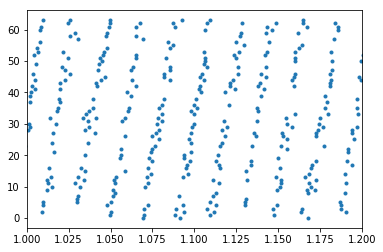

In [295]:
plot(G1e_sp.t/second,G1e_sp.i,'.')
xlim([1,1.2])

In [227]:
group1 = {'weights': W1_e2i, 'Em': 3, 'stype': 0, 'ttype': 1}
group2 = {'weights': W1_i2e, 'Em': 0, 'stype': 1, 'ttype': 0}
group3 = {'weights': W1_i2i, 'Em': 0, 'stype': 1, 'ttype': 1}

In [307]:
def print_exc_syn(group):
    M = shape(group['weights'])
    for i in range(10):
        print('{}:'.format(i), end=' ')
        for j in range(M[1]):
            if ~isnan(group['weights'][i,j]):
                print(j, (group['weights'][i,j]/5).astype(int), group['Em'])#, end=' ')
        print()
        print()

In [268]:
def make_event(index, addr_x, wm, em_sel, wt=0, chip_sel=1, thr_switch=0, debug=0):
    if(debug):
        print("\tMaking event..\n");

    wm_pos = 0;
    wt_pos = 5;
    row_pos = 10;
    col_pos = 16;
    em_sel_pos = 22;
    chip_sel_pos = 24;
    col_sel_pos = 28;
    addr_x_pos = 29;
    thr_switch_pos = 30;
    num_rows = 34;
    num_cols = 30;
    col_sel = 1;

    row = int(index/num_cols);
    col = int(index%num_rows);
    row_i = (row<<row_pos) & (0b11111<<row_pos);
    col_i = (col<<col_pos) & (0b11111<<col_pos);
    addrx_i = (addr_x<<addr_x_pos) & (0b11111<<addr_x_pos);
    wm_i = (wm<<wm_pos) & (0b11111<<wm_pos);
    wt_i = (wt<<wt_pos) & (0b11111<<wt_pos);
    em_i = (em_sel<<em_sel_pos) & (0b11111<<em_sel_pos);
    cs_i = (chip_sel<<chip_sel_pos) & (0b11111<<chip_sel_pos);
    col_sel_i = (col_sel<<col_sel_pos) & (0b11111<<col_sel_pos);
    thr_sw_i = (thr_switch<<thr_switch_pos) & (0b11111<<thr_switch_pos);

    out_event = row_i | col_i | addrx_i | wm_i | wt_i | em_i | cs_i | col_sel_i | thr_sw_i;
    out_event = out_event & 0xffffffff
    
    if(debug):
        print("\t\tout event:",end=' ')
        print(format(out_event, '032b'))

    return out_event;

In [305]:
def print_exc_syn2(group):
    M = shape(group['weights'])
    for i in range(M[0]):
        print('{}:'.format(i+30*34*group['stype']), end='')
        for j in range(M[1]):
            if ~isnan(group['weights'][i,j]):
                print(make_event(j, group['ttype'], int(group['weights'][i,j]/5), group['Em']), end=' ')
        print()

In [308]:
print_exc_syn(group1)

0: 0 31 3
1 31 3
2 30 3
3 28 3
4 26 3
5 23 3
6 20 3
7 17 3
8 15 3
9 12 3
10 10 3
11 8 3
12 6 3
13 5 3
14 4 3
15 3 3
16 2 3
17 2 3
18 2 3
19 1 3
20 1 3
21 1 3
22 1 3
42 1 3
43 1 3
44 1 3
45 1 3
46 2 3
47 2 3
48 2 3
49 3 3
50 4 3
51 5 3
52 6 3
53 8 3
54 10 3
55 12 3
56 15 3
57 17 3
58 20 3
59 23 3
60 26 3
61 28 3
62 30 3
63 31 3


1: 0 31 3
1 31 3
2 31 3
3 30 3
4 28 3
5 26 3
6 23 3
7 20 3
8 17 3
9 15 3
10 12 3
11 10 3
12 8 3
13 6 3
14 5 3
15 4 3
16 3 3
17 2 3
18 2 3
19 2 3
20 1 3
21 1 3
22 1 3
23 1 3
43 1 3
44 1 3
45 1 3
46 1 3
47 2 3
48 2 3
49 2 3
50 3 3
51 4 3
52 5 3
53 6 3
54 8 3
55 10 3
56 12 3
57 15 3
58 17 3
59 20 3
60 23 3
61 26 3
62 28 3
63 30 3


2: 0 30 3
1 31 3
2 31 3
3 31 3
4 30 3
5 28 3
6 26 3
7 23 3
8 20 3
9 17 3
10 15 3
11 12 3
12 10 3
13 8 3
14 6 3
15 5 3
16 4 3
17 3 3
18 2 3
19 2 3
20 2 3
21 1 3
22 1 3
23 1 3
24 1 3
44 1 3
45 1 3
46 1 3
47 1 3
48 2 3
49 2 3
50 2 3
51 3 3
52 4 3
53 5 3
54 6 3
55 8 3
56 10 3
57 12 3
58 15 3
59 17 3
60 20 3
61 23 3
62 26 3
63 28 3


3: 0 28

In [289]:
print_exc_syn2(group1)

0:834666527 834732063 834797598 834863132 834928666 834994199 835059732 835125265 835190799 835256332 835321866 835387400 835452934 835518469 835584004 835649539 835715074 835780610 835846146 835911681 835977217 836042753 836108289 835191809 835257345 835322881 835388417 835453954 835519490 835585026 835650563 835716100 835781637 835847174 835912712 835978250 836043788 836109327 836174865 836240404 836305943 836372506 836438044 836503582 836569119 
1:834666527 834732063 834797599 834863134 834928668 834994202 835059735 835125268 835190801 835256335 835321868 835387402 835452936 835518470 835584005 835649540 835715075 835780610 835846146 835911682 835977217 836042753 836108289 836173825 835257345 835322881 835388417 835453953 835519490 835585026 835650562 835716099 835781636 835847173 835912710 835978248 836043786 836109324 836174863 836240401 836305940 836372503 836438042 836503580 836569118 
2:834666526 834732063 834797599 834863135 834928670 834994204 835059738 835125271 835190804 83

In [290]:
def print_inh_syn2(i2e,i2i):
    M = shape(i2e['weights'])
    for i in range(M[0]):
        print('{}:'.format(i+30*34*i2e['stype']), end='')
        for j in range(M[1]):
            if ~isnan(i2e['weights'][i,j]):
                print(make_event(j, i2e['ttype'], int(i2e['weights'][i,j]/5), i2e['Em']), end=' ')
            if ~isnan(i2i['weights'][i,j]):
                print(make_event(j, i2i['ttype'], int(i2i['weights'][i,j]/5), i2i['Em']), end=' ')
        print()

In [291]:
print_inh_syn2(group2, group3)

1020:285212673 822083615 285278209 822149151 822214686 822280220 822345754 822411287 822476820 822542353 822607887 822673420 822738954 822804488 822870022 822935557 823001092 823066627 823132162 823197698 823263234 823328769 286523393 823394305 286588929 823459841 286654465 823525377 286720001 286785537 286851074 286916610 286982147 287047683 287113220 287179782 287245319 285213705 285279243 285213709 285279248 285344786 285410325 285475864 285541402 285606940 285672478 285738015 822608897 285803551 822674433 285869086 822739969 285934621 822805505 286000155 822871042 286065689 822936578 286131222 823002114 286196755 823067651 286262289 823133188 286327822 823198725 286393356 823264262 286458889 823329800 286524424 823395338 286589958 823460876 286655493 823526415 286721028 823591953 286786563 823657492 286852098 823723031 286918658 823789594 286984193 823855132 287049729 823920670 287115265 823986207 
1021:285212673 822083615 285278209 822149151 285343745 822214687 822280222 822345756

1053:285212679 285278217 285343755 285409293 285474832 285540370 285605909 285671448 285736986 285802524 285868062 285933599 822804481 285999135 822870017 286064670 822935553 286130205 823001089 286195739 823066626 286261273 823132162 286326806 823197698 286392339 823263235 286457873 823328772 286523406 823394309 286588940 823459846 286654473 823525384 286720008 823590922 286785542 823656460 286851077 823721999 286916612 823787537 286982147 823853076 287047682 823918615 287113218 823984154 287179777 824050716 287245313 824116254 285213697 822084639 285279233 822150175 285213697 822084639 822150174 822215708 822281242 822346775 822412308 822477841 822543375 822608908 822674442 822739976 822805510 822871045 822936580 823002115 823067650 823133186 823198722 823264257 286458881 823329793 286524417 823395329 286589953 823460865 286655489 286721025 286786562 286852098 286918659 286984195 287049732 287115270 
1054:285212678 285278215 285343753 285409291 285474829 285540368 285605906 285671445

In [397]:
def poissonSpikeGen(rate=3*kHz, dt=100*us, t=1*second, num_neur=1):
    bins = int(t/dt)
    print(bins)
    output = rand(num_neur, bins) < rate*dt
    time = arange(0,t-dt,dt)
    return time, output

In [398]:
time, out = poissonSpikeGen(rate=3*kHz, dt=100*us, t=10*ms, num_neur=64)

100


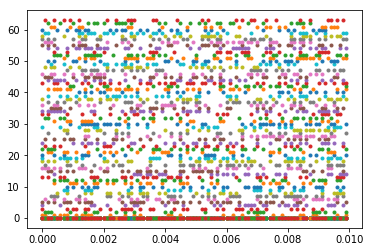

In [399]:
for i in range(M):
    plot(time,out[i]*i,'.'); 

In [410]:
for i, t in enumerate(time):
    print("{}:".format(round(t/us)),end=' ')
    for j in range(M):
        if out[j,i]:
            print('{}'.format(make_event(j, 0, 5, 3)), end=' ')
    print()

0: 297861125 297992197 298057733 298123269 298647557 298844165 298975237 299040773 299106309 299237381 299368453 299696133 297862149 297796613 297927685 298058757 298386437 298583045 299172869 299303941 299369477 299501573 
100: 297861125 297926661 298188805 298844165 298909701 299302917 299433989 297796613 298517509 298714117 299238405 299435013 299698181 
200: 297926661 298123269 298647557 298778629 298844165 298975237 299171845 299237381 299565061 297796613 297862149 297796613 297993221 298124293 298255365 298451973 298517509 298845189 299107333 299172869 299238405 299303941 299435013 299632645 
300: 297926661 298254341 298778629 299171845 299237381 297796613 297862149 298517509 298583045 298714117 298779653 299238405 299567109 
400: 297861125 298123269 298188805 298254341 298516485 298582021 298713093 298844165 298975237 299106309 299237381 299302917 299433989 299828229 297796613 297862149 297927685 298255365 298386437 298451973 298583045 298714117 298845189 298976261 299041797 299